# Training Metrics Analysis
This notebook loads `runs/all_training_metrics.csv` (the master log you created while training) and plots trends for:
- reward
- total_loss
- policy_loss
- value_loss
- entropy

## How to use
1. Set `CSV_PATH` if your file lives elsewhere.
2. Run the **Setup** cell.
3. Use the helper functions to plot per-run/per-label curves.
4. Optionally set `rolling` window (e.g., 50) to smooth noisy curves.


In [4]:
# === Setup ===
stamp = "20250817_022806"
CSV_PATH = f"runs/all_training_metrics_{stamp}.csv"  # change this if needed

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from drl_framework import params

# Load
df = pd.read_csv(CSV_PATH)

# Basic sanity check / peek
print("Rows:", len(df))
print("Columns:", list(df.columns))
print("\nUnique run_id:", df['run_id'].nunique())
print("Unique labels:", sorted(df['label'].unique()))
print("\nSample rows:")
display(df.head())

# Sort for consistency
df = df.sort_values(['run_id','label','episode']).reset_index(drop=True)


Rows: 13000
Columns: ['run_id', 'label', 'episode', 'reward', 'policy_loss', 'value_loss', 'entropy', 'total_loss']

Unique run_id: 2
Unique labels: ['Global', 'Individual_0', 'Individual_1', 'Individual_2', 'Individual_3', 'Individual_4']

Sample rows:


,run_id,label,episode,reward,policy_loss,value_loss,entropy,total_loss
0,a3c_20250817_022806,Global,1,3893.912223,0.003655,543151.678125,0.676044,54315.173047
1,a3c_20250817_022806,Global,2,3916.424416,-0.000145,356668.368750,0.662617,35666.837109
2,a3c_20250817_022806,Global,3,4041.622209,-0.071589,470467.515625,0.575701,47046.681641
3,a3c_20250817_022806,Global,4,4150.471990,-0.038847,365195.396875,0.628642,36519.499609
4,a3c_20250817_022806,Global,5,3982.507816,0.051027,297198.803125,0.595399,29719.930859


In [2]:
# === Helpers ===
def get_df(run_id=None, label=None):
    sub = df.copy()
    if run_id is not None:
        sub = sub[sub['run_id'] == run_id]
    if label is not None:
        sub = sub[sub['label'] == label]
    return sub.sort_values('episode')

def plot_metric(run_id=None, label=None, metric='reward', rolling=None, save=False, outdir='plots'):
    data = get_df(run_id, label)
    if data.empty:
        print("No data for the given filter.")
        return
    y = data[metric]
    if rolling is not None and rolling > 1:
        y = y.rolling(rolling, min_periods=1).mean()

    plt.figure()
    plt.plot(data['episode'], y)
    plt.xlabel('Episode')
    plt.ylabel(metric.replace('_',' ').title())
    title = f"{metric.replace('_',' ').title()} vs Episode"
    if label: title += f" - {label}"
    if run_id: title += f" - {run_id}"
    plt.title(title)
    plt.tight_layout()
    if save:
        Path(outdir).mkdir(parents=True, exist_ok=True)
        fname = f"{metric}_{(label or 'All')}_{(run_id or 'All')}.png".replace('/','-')
        plt.savefig(Path(outdir)/fname, dpi=180)
    plt.show()

def plot_compare_labels(run_id, metric='reward', rolling=None):
    data = df[df['run_id'] == run_id]
    if data.empty:
        print("No data for this run_id.")
        return
    labels = sorted(data['label'].unique())
    plt.figure()
    for lb in labels:
        sub = data[data['label'] == lb].sort_values('episode')
        series = sub[metric]
        if rolling is not None and rolling > 1:
            series = series.rolling(rolling, min_periods=1).mean()
        plt.plot(sub['episode'], series, label=lb)
    plt.xlabel('Episode')
    plt.ylabel(metric.replace('_',' ').title())
    plt.title(f"{metric.replace('_',' ').title()} vs Episode - {run_id}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Quick start
- The next cell picks the most recent `run_id` by default and label `"Global"`.
- Adjust `RUN_ID` and `LABEL` as needed.


In [ ]:
# Pick defaults
# RUN_ID = df['run_id'].iloc[-1] if len(df) else None
RUN_ID = "individual_20250814_024420"
LABEL = "Global"  # or e.g., "Individual_0"

# Single-label plots (saved as PNG too)
plot_metric(RUN_ID, LABEL, 'reward', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'total_loss', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'policy_loss', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'value_loss', rolling=50, save=True)
plot_metric(RUN_ID, LABEL, 'entropy', rolling=50, save=True)

# Compare all labels within a run (one chart per metric)
plot_compare_labels(RUN_ID, 'reward', rolling=50)
plot_compare_labels(RUN_ID, 'total_loss', rolling=50)
plot_compare_labels(RUN_ID, 'policy_loss', rolling=50)
plot_compare_labels(RUN_ID, 'value_loss', rolling=50)
plot_compare_labels(RUN_ID, 'entropy', rolling=50)


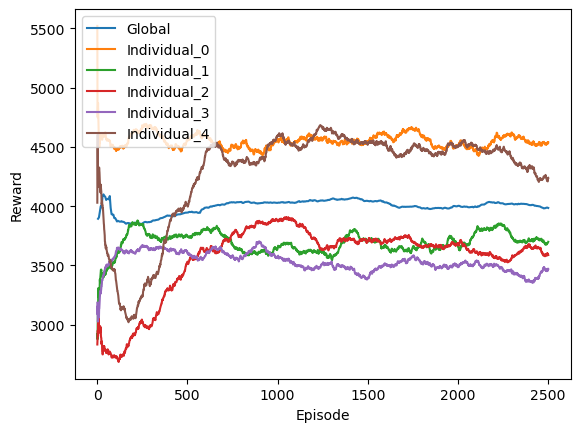

In [5]:
plt.figure()
rolling = 100

for label in sorted(df['label'].unique()):
    if label == 'Global':
        plt.plot(df[df['label']==label]['episode']*params.n_workers, df[df['label']==label]['reward'].rolling(rolling, min_periods=1).mean(), label=label)
    else:
        plt.plot(df[df['label']==label]['episode'], df[df['label']==label]['reward'].rolling(rolling, min_periods=1).mean(), label=label)

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()